In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
sys.path.append("..")
from object_detection.utils import ops as utils_ops

D:\PYTHON3\envs\TF\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
# This is needed to display the images.
%matplotlib inline


# Dont forget the to compile the protos with Protoc, I used the 3.4.0 version

In [3]:
# What model to download.
MODEL_NAME = 'mask_rcnn_inception_v2_coco_2018_01_28'
# http://download.tensorflow.org/models/object_detection/mask_rcnn_resnet50_atrous_coco_2018_01_28.tar.gz
#http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

# If you haven't downloaded it

In [4]:
# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#   file_name = os.path.basename(file.name)
#   if 'frozen_inference_graph.pb' in file_name:
#     tar_file.extract(file, os.getcwd())

In [5]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
from glob import glob

TEST_IMAGE_PATHS = glob('./test_images/*.jpg')
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [6]:
class predictor(object):

    def __init__(self,modelpath):
        
        import numpy as np
        import os
        import six.moves.urllib as urllib
        import sys
        import tarfile
        import tensorflow as tf
        import zipfile
        import collections
        import numpy as np
        import six
        import tensorflow as tf
        from collections import defaultdict
        from io import StringIO

        
        self.modelpath = modelpath
#         self.labelpath = labelpath
#         self.categorypath = categorypath
        detection_graph = tf.Graph()
        with detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(self.modelpath, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        self.graph = detection_graph
        
        
        self.image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        self.boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')
        self.scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
        self.classes_tensor = detection_graph.get_tensor_by_name('detection_classes:0')
        self.mask_tensor = detection_graph.get_tensor_by_name('detection_masks:0')
        self.tf = tf

        
    def predict(self,image_path,thresh=0.7):
        import cv2
        import numpy as np
        import collections
        from functools import partial
        with self.graph.as_default():
            with self.tf.Session(graph=self.graph) as sess:
                image = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
                
                ops = self.tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in ['num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks']:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                      tensor_dict[key] = self.tf.get_default_graph().get_tensor_by_name(
                          tensor_name)
                if 'detection_masks' in tensor_dict:
                    # The following processing is only for single image
                    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, image.shape[0], image.shape[1])
                    detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(
                        detection_masks_reframed, 0)
                    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

                # Run inference
                output_dict = sess.run(tensor_dict,
                                     feed_dict={image_tensor: np.expand_dims(image, 0)})
        
                cleanmask = []
                for idx,c in enumerate(output_dict['detection_classes'][0]):
                    if c == 3 :
                        cleanmask.append(output_dict['detection_masks'][0][idx])
                zz = cleanmask[0]
                for c in range(1,len(cleanmask)):

                    zz = np.add(zz,cleanmask[c])
                return (zz)

In [7]:
p = predictor(PATH_TO_CKPT)

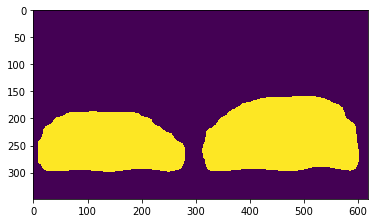

In [8]:
plt.imshow(p.predict(TEST_IMAGE_PATHS[0]))

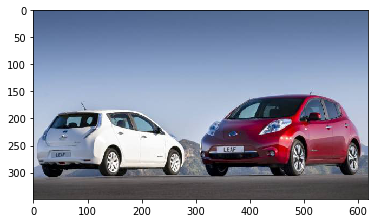

In [11]:
plt.imshow(cv2.cvtColor(cv2.imread(TEST_IMAGE_PATHS[0]),cv2.COLOR_BGR2RGB))

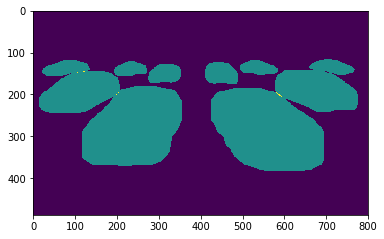

In [9]:
plt.imshow(p.predict(TEST_IMAGE_PATHS[1]))

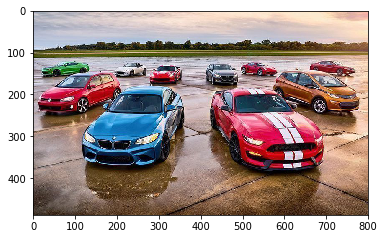

In [12]:
plt.imshow(cv2.cvtColor(cv2.imread(TEST_IMAGE_PATHS[1]),cv2.COLOR_BGR2RGB))